Primeiro, vamos realizar a importação de todas as bibliotecas que usaremos.

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

Agora, vamos importar nossos dados.

In [157]:
df_test = pd.read_csv('../test.csv')
df = pd.read_csv('../train.csv')

In [158]:
pd.set_option('display.max_columns', None) # Configuracao para mostrar todas as colunas

## Entendendo o significado de todas as colunas

É de extrema importância entender todas as colunas, por isso, vamos copiar e colar o significado delas:

- track_id: O ID único de cada música
    
- artists: Nome dos(as) artistas que performaram a música, separados por ';'
    
- album_name: Nome do álbum no qual aparece a música
    
- track_name: Nome da música
    
- duration_ms: A duração da música em milissegundos
    
- explicit: Boolean indicando se a música possui conteúdo explícito
    
- danceability: Descreve quanto uma música é "dançante" (0.0 = menos dançante, 1.0 = mais dançante)
    
- energy: Representa a intensidade e atividade de uma música (0.0 = baixa energia, 1.0 = alta energia)
    
- key: A tonalidade musical da faixa mapeada usando a notação padrão de Classe de Altura (12 notas musicais)
    
- loudness: Nível geral de volume da faixa em decibéis (dB)
    
- mode: Indica a modalidade (maior ou menor) da faixa
    
- speechiness: Detecta a presença de palavras faladas na faixa
    
- acousticness: Medida de confiança sobre se a faixa é acústica (0,0 = não acústica, 1,0 = altamente acústica)
    
- instrumentalness: Prediz se uma faixa contém vocais (0,0 = contém vocais, 1,0 = instrumental)
    
- liveness: Detecta a presença de uma audiência na gravação (0,0 = gravação em estúdio, 1,0 = performance ao vivo)
    
- valence: Mede a positividade musical transmitida por uma faixa (0,0 = negativa, 1,0 = positiva)
    
- tempo: Tempo estimado da faixa em batidas por minuto (BPM)
    
- time_signature: Assinatura de tempo estimada da faixa (de 3 a 7)
    
- track_genre: O gênero da música
    
- popularity_target: Boolean indicando se a música é popular ou não

Realizando a análise das colunas, fiquei em dúvida sobre a diferença entre a coluna 'tempo' e 'time_signature'. Por isso, realizei uma análise mais profunda no significado delas:

* tempo (Batidas por minuto):
   * O tempo representa a velocidade ou ritmo de uma faixa, medido em batidas por minuto (BPM).
   * O tempo médio é de cerca de 122 BPM, o que representa um ritmo moderado e enérgico.
   * O tempo mínimo é 0 BPM (o que pode indicar dados ausentes ou faixas muito lentas), e o máximo é cerca de 223 BPM (muito rápido).

* time_signature (Fórmula de compasso):
   * A fórmula de compasso representa a estrutura rítmica de uma faixa, indicando quantas batidas existem em cada compasso e qual valor de nota representa uma batida.
   * Os valores geralmente variam de 3 a 7, sendo 4 o mais comum (representando o compasso 4/4, que é padrão em muitos gêneros).
   * A partir das estatísticas, podemos ver que a mediana e os percentis 25 e 75 são 4, confirmando que o compasso 4/4 é realmente o mais comum.
   * O mínimo de 0 pode indicar dados ausentes ou fórmulas de compasso não convencionais.

Primeiro dou uma olhada por cima dos dados apenas para entender quais colunas são númericas e categóricas. Também tenho a intenção de ver elas como dados reais e por isso chamo o comando `df.head(3)`

In [159]:
df.head(3)

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,41996,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.849,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.320,141.793,4,goth,0
1,76471,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.190,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.133,83.685,4,opera,0
2,54809,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.509,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.544,90.459,3,idm,1


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_unique_id    79800 non-null  int64  
 1   track_id           79800 non-null  object 
 2   artists            79800 non-null  object 
 3   album_name         79800 non-null  object 
 4   track_name         79800 non-null  object 
 5   duration_ms        79800 non-null  int64  
 6   explicit           79800 non-null  bool   
 7   danceability       79800 non-null  float64
 8   energy             79800 non-null  float64
 9   key                79800 non-null  int64  
 10  loudness           79800 non-null  float64
 11  mode               79800 non-null  int64  
 12  speechiness        79800 non-null  float64
 13  acousticness       79800 non-null  float64
 14  instrumentalness   79800 non-null  float64
 15  liveness           79800 non-null  float64
 16  valence            798

Agora partindo para uma análise mais profunda das colunas numéricas, começo com uma análise da estatística descritiva de cada coluna.

In [161]:
df.describe()

,track_unique_id,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target
count,79800.000000,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,57140.494048,2.279022e+05,0.567318,0.641529,5.307043,-8.263741,0.637732,0.084750,0.314979,0.157319,0.213313,0.474267,122.076559,3.902556,0.487845
std,32993.196225,1.050599e+05,0.173110,0.251441,3.562186,5.035504,0.480659,0.105657,0.332512,0.310792,0.190075,0.259010,29.941937,0.434284,0.499855
min,0.000000,1.338600e+04,0.000000,0.000019,0.000000,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28450.500000,1.744360e+05,0.456000,0.472000,2.000000,-10.006000,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,99.081250,4.000000,0.000000
50%,57234.000000,2.128130e+05,0.581000,0.685000,5.000000,-7.012000,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,122.009000,4.000000,0.000000
75%,85774.250000,2.614260e+05,0.695000,0.854000,8.000000,-5.000000,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,140.054000,4.000000,1.000000
max,113998.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.605000,5.000000,1.000000


Com o output acima, já é possível observar que valores iguais a 0 em 'tempo' e 'time_signature' provavelmente são missing values. Chegamos a essa conclusão porque músicas com 0 BPM não existem, mesmo muito lentas. E 'time_sigture' já comenta na definição das colunas que os valores vão de 3 a 7, ou seja, 0 é incorreto. Não realizamos a correção desses valores faltantes nesse exato momento, mas em breve voltaremos com eles.

## Exploração e Visualização dos Dados

Agora, na intenção de entender os dados e descobrir padrões, vamos realizar uma exploração e visualização dos dados! Para isso, vamos utilizar bibliotecas como Matplot e Seaborn. Nossa missão aqui é descobrir padrões, correlações e tendências nos dados. Vamos usar visualizações eficazes para comunicar os insights e justificar nossas futuras escolhas de features e modelos.

In [162]:
# Definindo um estilo para nossos graficos e alterando o tamanho padrão das figuras geradas pelo Matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Para o começo da nossa análise, é importante saber a quantidade de músicas que são populares ou não e saber como está a distribuição entre elas. No gráfico gerado a seguir, é possível observar que existe uma divisão bem harmoniosa entre músicas populares e não populares.

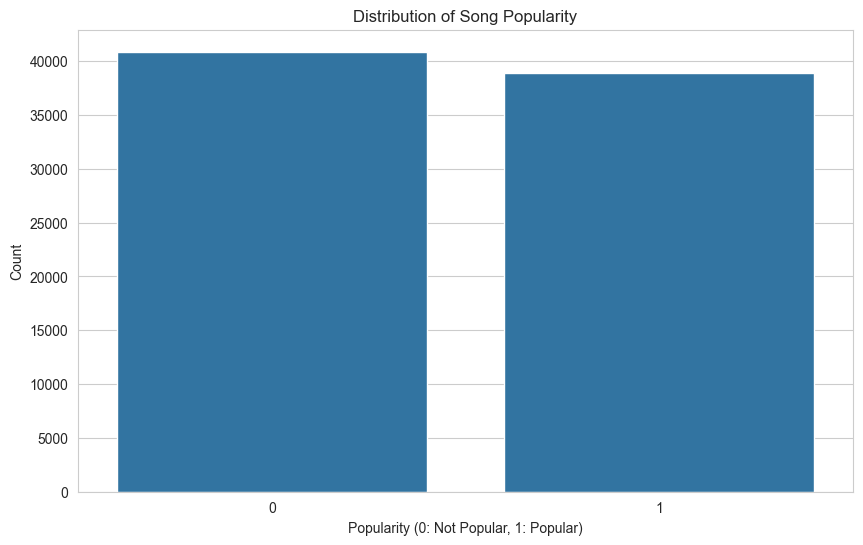

In [163]:
plt.figure(figsize=(10, 6))
sns.countplot(x='popularity_target', data=df)
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity (0: Not Popular, 1: Popular)')
plt.ylabel('Count')
plt.show()

Partindo com nossa análise, vamos agora observar nossas variáveis numéricas e a relação entre elas. O Heatmap é um gráfico perfeito para isso que demonstra as relações entre as colunas. Resumindo bastante funciona da forma a seguir: 

Os valores de correlação variam de -1 a 1:

- **+1**: Correlação positiva perfeita. À medida que uma variável aumenta, a outra também aumenta.
- **-1**: Correlação negativa perfeita. À medida que uma variável aumenta, a outra diminui.
- **0**: Nenhuma correlação. As duas variáveis não afetam uma à outra.

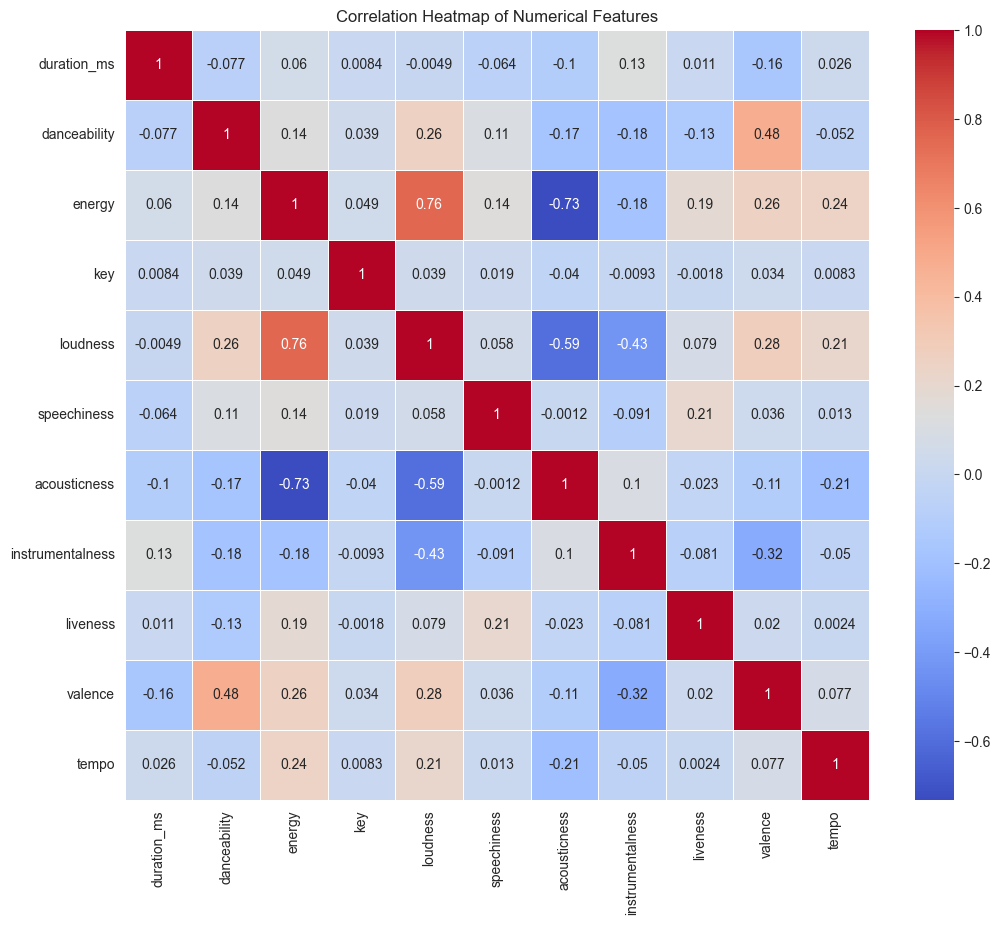

In [164]:
numerical_features = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Realizando a análise do Heatmap acima, é possível identificar alguns padrões importantes sobre nossa base de dados.

1. Correlação forte entre 'energy' e 'loudness': Existe uma correlação positiva forte (0.76) entre 'energy' e 'loudness', indicando que músicas mais enérgicas tendem a ser mais altas.

2. Correlação negativa entre 'acousticness' e 'energy': Há uma forte correlação negativa (-0.73) entre 'acousticness' e 'energy', sugerindo que músicas mais acústicas tendem a ser menos enérgicas.

3. Correlação negativa entre 'acousticness' e 'loudness': Similarmente, existe uma correlação negativa moderada (-0.59) entre 'acousticness' e 'loudness', indicando que músicas acústicas tendem a ser menos altas.

4. Correlação positiva entre 'danceability' e 'valence': Há uma correlação positiva moderada (0.48) entre 'danceability' e 'valence', sugerindo que músicas mais dançantes tendem a ter um tom emocional mais positivo.

5. Correlação negativa entre 'instrumentalness' e 'loudness': Observa-se uma correlação negativa moderada (-0.43) entre 'instrumentalness' e 'loudness', indicando que músicas mais instrumentais tendem a ser menos altas.

6. Pouca correlação com 'duration_ms': A 'duration_ms' tem correlações fracas com a maioria das outras características, sugerindo que o comprimento da música não está fortemente relacionado com suas outras propriedades acústicas.

7. Correlações fracas com 'key': A 'key' tem correlações muito fracas com outras características, indicando que não há uma relação forte entre a tonalidade e outros aspectos musicais neste conjunto de dados.

8. Correlações moderadas com 'valence': A 'valence' tem correlações moderadas positivas com 'danceability' (0.48) e 'energy' (0.26), sugerindo que músicas mais positivas tendem a ser mais dançantes e enérgicas.

9. Pouca correlação entre 'tempo' e outras características: O 'tempo' da música tem correlações relativamente fracas com outras características, com a mais forte sendo com 'energy' (0.24).

10. Correlação fraca entre 'speechiness' e outras características: 'Speechiness' tem correlações geralmente fracas com outras características, com a mais notável sendo com 'liveness' (0.21).

11. 'Liveness' tem correlações fracas: A característica 'liveness' não mostra correlações fortes com nenhuma outra característica, sugerindo que é relativamente independente das outras propriedades musicais.

Saber desses padrão será importante para quando começarmos a selecionar as features para o treinamento do nosso modelo! Porque aqui é possível observar que alguns colunas estão extremamente ligadas com outras.

Agora, queremos entender como diferentes características musicais se relacionam com a popularidade das músicas. Por isso, vamos criar alguns gráficos para realizar essa visualização.

Com essa análise, vamos identificar quais características musicais têm maior influência na popularidade de uma música.

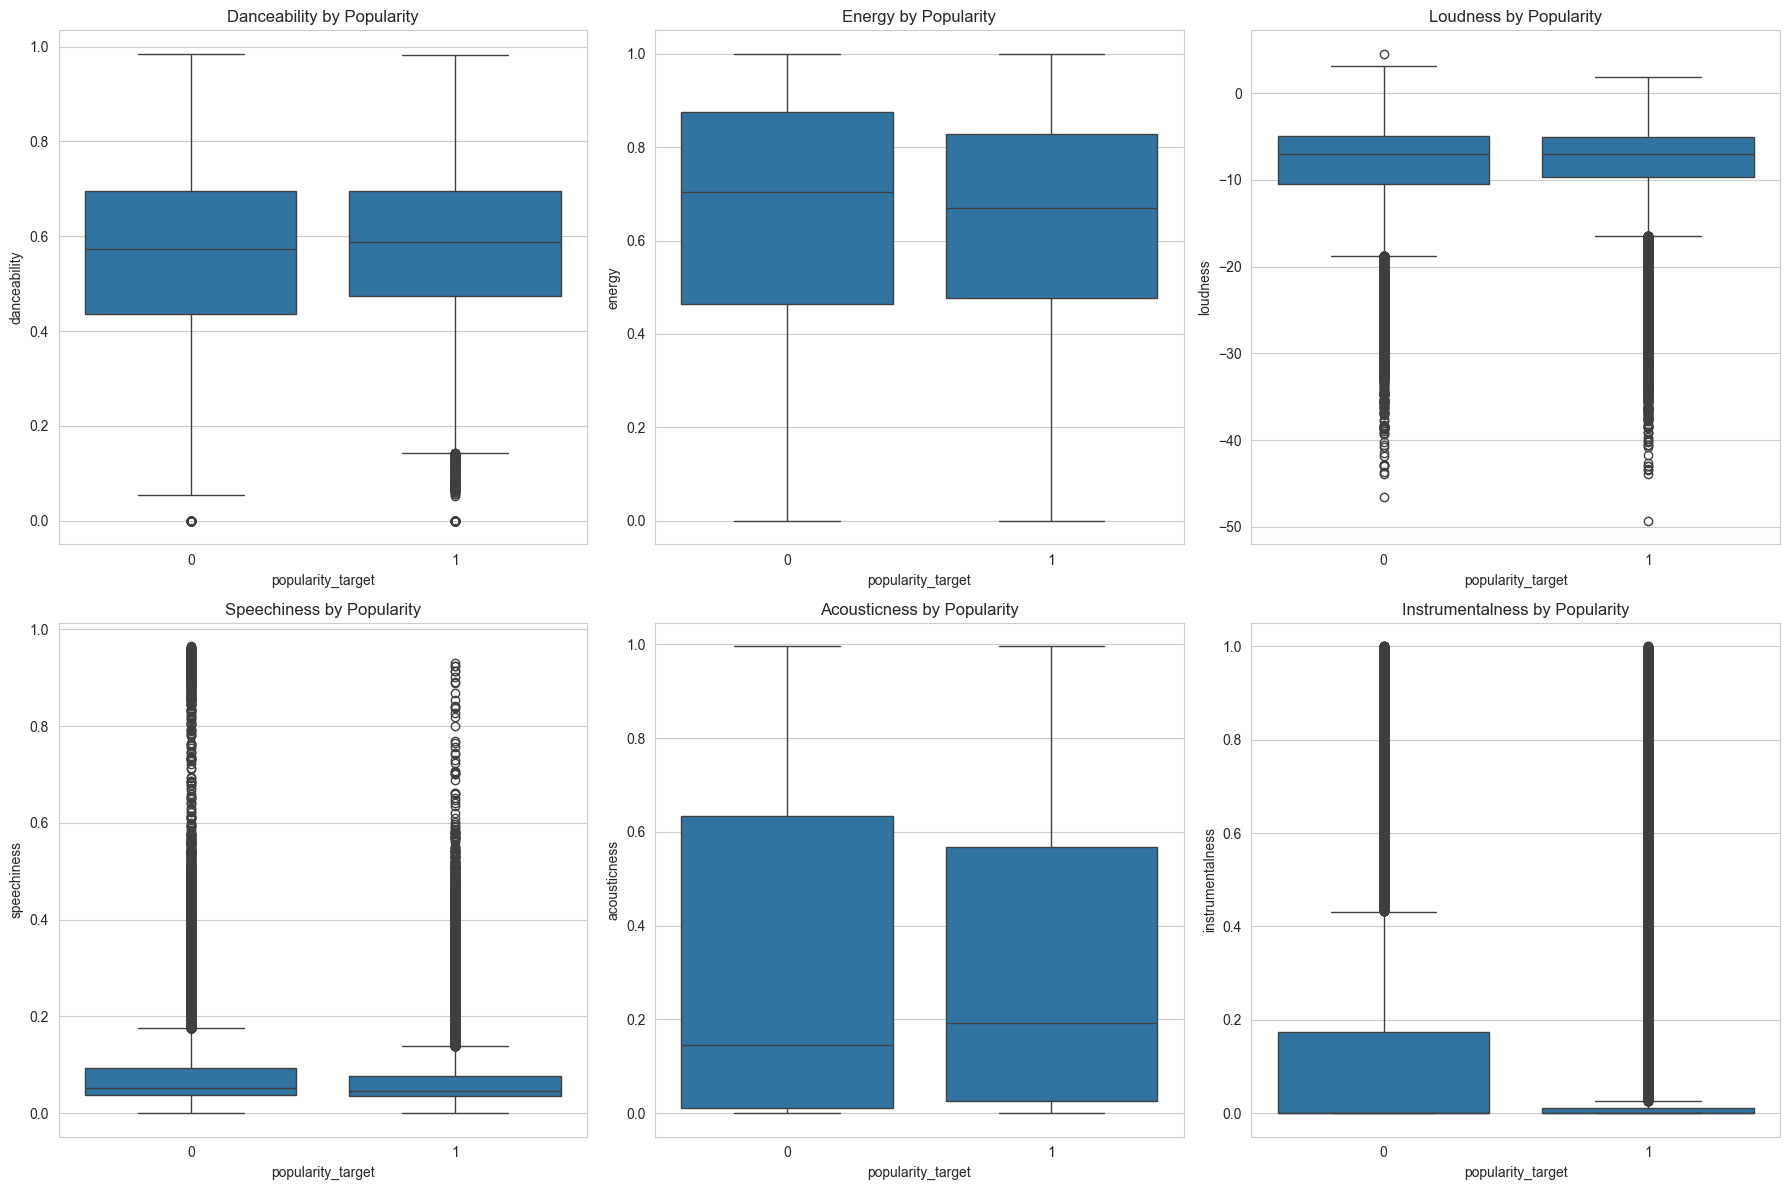

In [165]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness']
for i, feature in enumerate(features):
    sns.boxplot(x='popularity_target', y=feature, data=df, ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title(f'{feature.capitalize()} by Popularity')
plt.tight_layout()
plt.show()

Observando o gráfico acima, conseguimos ter alguns insights.

1. Danceability (Dançabilidade):

Há uma ligeira tendência de músicas populares (1) terem maior dançabilidade.
A diferença é pequena, mas notável, o que sugere que músicas mais dançantes têm uma probabilidade um pouco maior de serem populares.

2.Instrumentalness (Instrumentalidade):

Músicas populares tendem a ter menor instrumentalidade.
Isso sugere que músicas com vocais são geralmente mais populares do que músicas puramente instrumentais.

Agora, para entender quais gêneros proporcionam mais sucessos às músicas, vamos criar um gráfico para visualizar os 10 melhores gêneros em termos de músicas populares.

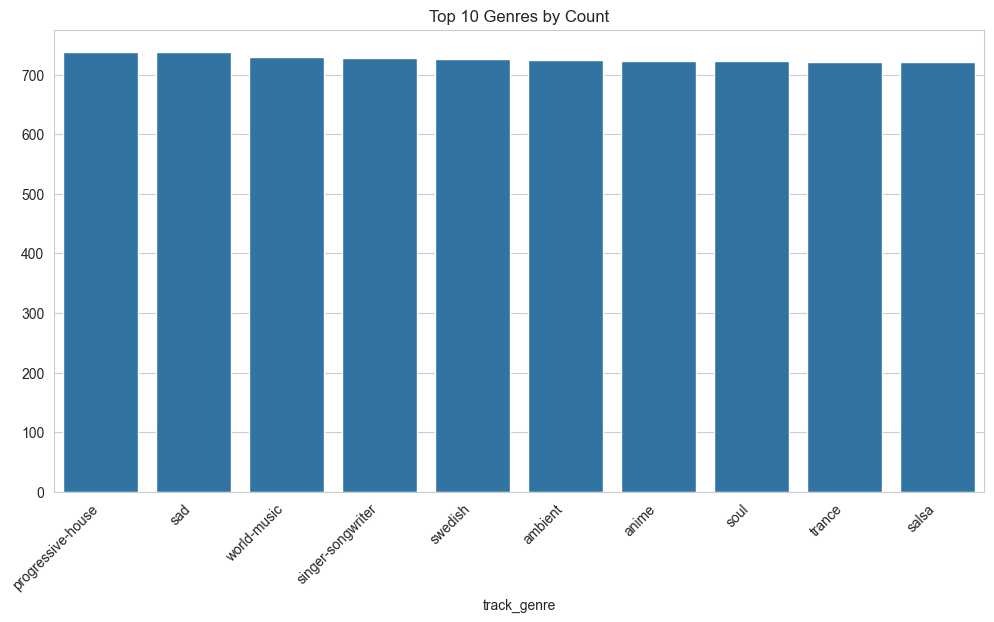

In [166]:
top_genres = df['track_genre'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title('Top 10 Genres by Count')
plt.xticks(rotation=45, ha='right')
plt.show()

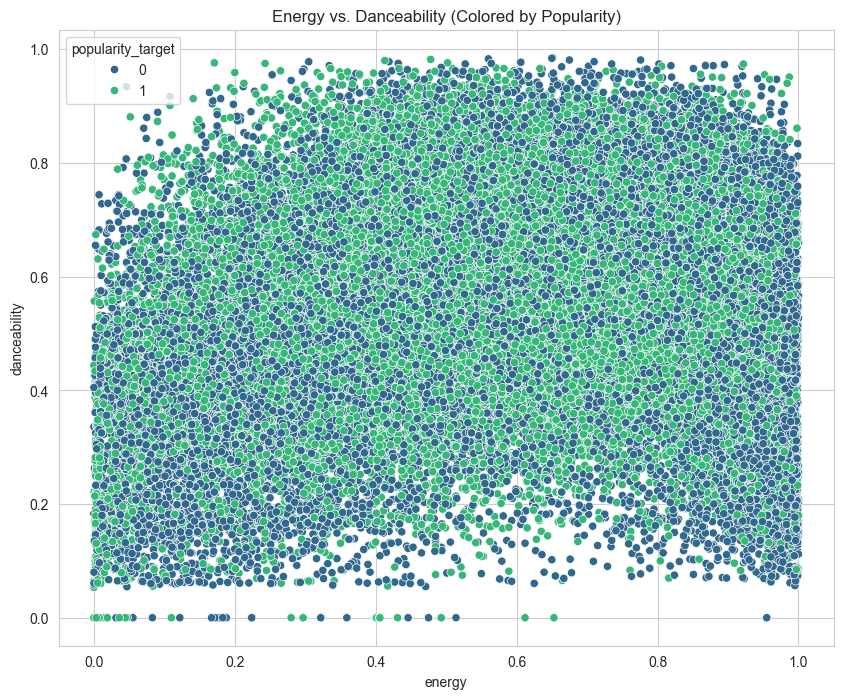

In [167]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='energy', y='danceability', hue='popularity_target', palette='viridis')
plt.title('Energy vs. Danceability (Colored by Popularity)')
plt.show()

Análisando o gráfico acima, podemos observar que a popularidade não parece ser exclusivamente determinada por altos níveis de energia e dançabilidade, já que músicas populares existem em diversos níveis de energia e dançabilidade, sugerindo que outros fatores também influenciam a popularidade.

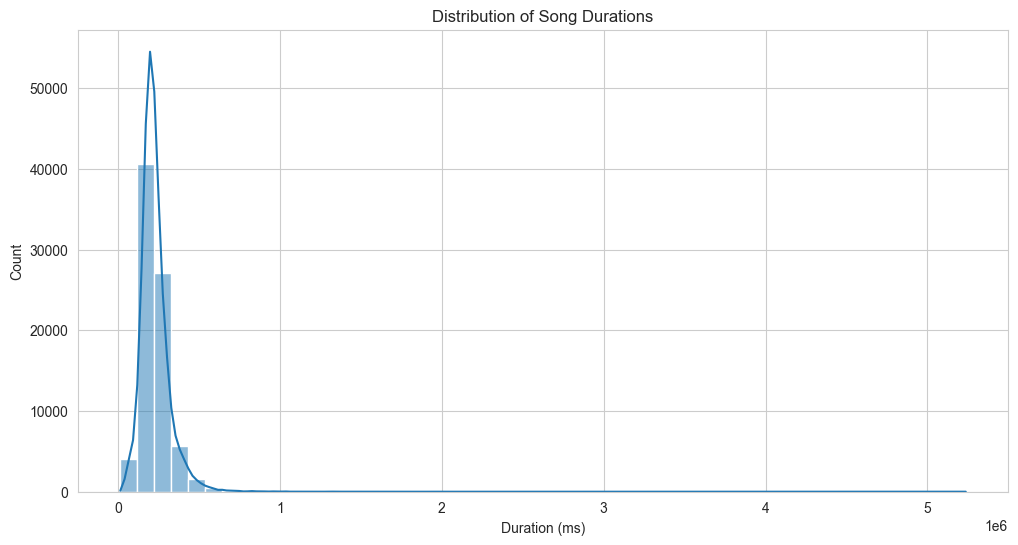

In [168]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='duration_ms', bins=50, kde=True)
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (ms)')
plt.show()

Observando a duração das músicas, podemos observar que há uma concentração muito alta de músicas com duração menor. Também observamos que existem músicas com durações extremamente longas. Estes podem ser álbuns inteiros, performances ao vivo, ou erros nos dados.

- A assimetria da distribuição pode afetar análises estatísticas, sendo necessário considerar transformações ou métodos robustos. Em breve voltaremos nesse tópico ao tratar os dados.

Já o gráfico de barras empilhadas abaixo apresenta uma comparação visual da proporção de conteúdo explícito entre músicas populares e não populares 

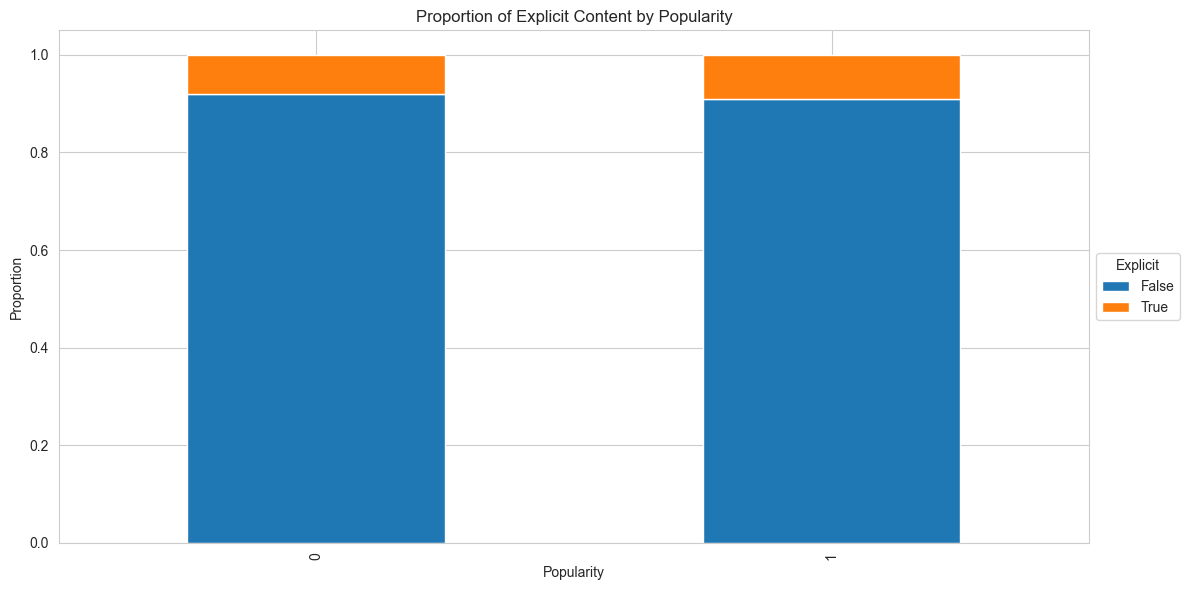

In [169]:
explicit_by_popularity = df.groupby('popularity_target')['explicit'].value_counts(normalize=True).unstack()
explicit_by_popularity.plot(kind='bar', stacked=True)
plt.title('Proportion of Explicit Content by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Proportion')
plt.legend(title='Explicit', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Observando o gráfico acima, podemos observar que:

1. A maioria das músicas, tanto populares quanto não populares, não contém conteúdo explícito.
2. Há uma ligeira tendência de músicas populares terem uma proporção um pouco maior de conteúdo explícito em comparação com as não populares.
3. A presença de conteúdo explícito não parece ser um fator determinante para a popularidade de uma música, dada a pequena diferença observada.

Agora para fechar nossa análise, vamos comparar a distribuição da duração das músicas entre as categorias de popularidade.

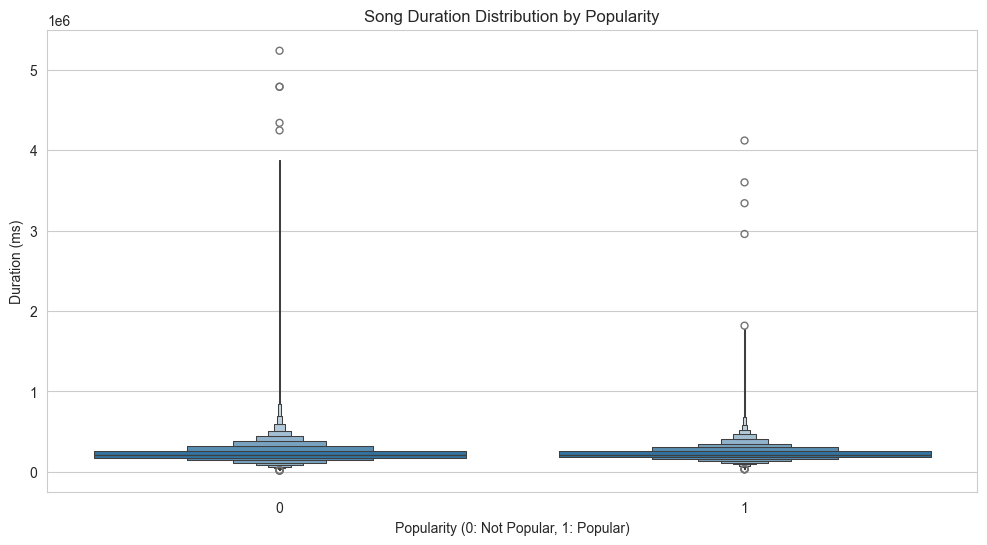

In [170]:
plt.figure(figsize=(12, 6))
sns.boxenplot(x='popularity_target', y='duration_ms', data=df)
plt.title('Song Duration Distribution by Popularity')
plt.xlabel('Popularity (0: Not Popular, 1: Popular)')
plt.ylabel('Duration (ms)')
plt.show()

Observando o gráfico acima, vemos que:

1. As medianas de duração para músicas populares e não populares são muito semelhantes, sugerindo que a duração por si só não é um forte indicador de popularidade.
2. A dispersão (representada pelo tamanho das caixas) é ligeiramente menor para músicas populares, indicando uma maior consistência na duração dessas faixas.
3. Existem muitos outliers em ambas as categorias, representando músicas com durações excepcionalmente longas.
4. As músicas populares parecem ter menos outliers extremos em comparação com as não populares, especialmente na faixa de duração mais longa.
5. A maioria das músicas, independentemente da popularidade, tem duração dentro de um intervalo relativamente estreito, como evidenciado pelo tamanho das caixas do boxplot.
6. Há uma leve tendência de músicas populares terem durações um pouco mais curtas, observável pela posição ligeiramente inferior da caixa para músicas populares.

Os insights mais importantes que encontramos em nossa análise incluem: a ligeira tendência de músicas populares terem maior energia e dançabilidade; a predominância de conteúdo não explícito em ambas as categorias de popularidade, com uma sutil inclinação para mais conteúdo explícito em músicas populares; e a observação de que a duração das músicas não é um forte indicador de popularidade, embora músicas populares tendam a ter durações mais consistentes. Além disso, notamos correlações significativas entre certas características musicais, como a relação positiva entre energia e volume (loudness), e negativa entre acústica e energia.

Ainda é muito cedo para entrarmos na escolha das features para nosso modelo, mas já é possível observar que não existe uma coluna em específica que determina a popularidade das músicas, com isso, é bastante provável que vamos utilizar todas as colunas para treinar nosso modelo, excluindo apenas as colunas de identificação.

## Formulação de Hipóteses

#### Hipótese 01: Influência da dançabilidade na era do TikTok

Com a popularização do TikTok, onde coreografias virais são frequentes, músicas mais dançantes podem ter maior probabilidade de se tornarem populares. Esta hipótese sugere uma correlação positiva entre a dançabilidade de uma música e sua popularidade.

Text(0, 0.5, 'Dançabilidade')

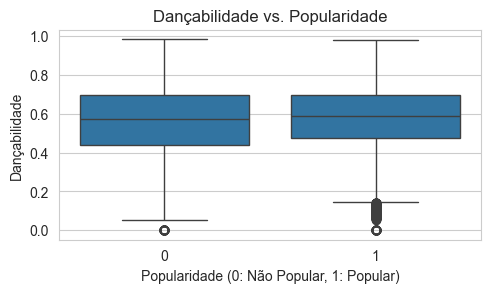

In [171]:
plt.subplot(2, 2, 1)
sns.boxplot(x='popularity_target', y='danceability', data=df)
plt.title('Dançabilidade vs. Popularidade')
plt.xlabel('Popularidade (0: Não Popular, 1: Popular)')
plt.ylabel('Dançabilidade')

É possível observar que a média de músicas dançantes é um pouco mais alto para músicas populares, mas a diferença não é tão grande assim, logo, não indica extrema importância se a música é dançante ou não para ela ser popular.

#### Hipótese 02: Conteúdo explícito em músicas de temática triste

Músicas categorizadas como "sad" ou emocionalmente intensas podem ter uma maior tendência a conter conteúdo explícito.

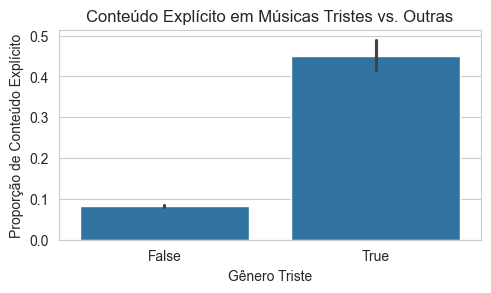

In [172]:
plt.subplot(2, 2, 2)
sad_genres = ['sad', 'melancholic', 'emotional']  # Ajuste conforme necessário
df['is_sad'] = df['track_genre'].isin(sad_genres)
sns.barplot(x='is_sad', y='explicit', data=df)
plt.title('Conteúdo Explícito em Músicas Tristes vs. Outras')
plt.xlabel('Gênero Triste')
plt.ylabel('Proporção de Conteúdo Explícito')
df = df.drop(columns='is_sad')

É possível observar que o conteúdo explícito está extremamente presente em músicas classificadas como 'sad', 'melancholic' ou 'emotional'. Comprovando nossa hipótese.

#### Hipótese 03: Popularidade de músicas com temática melancólica

Músicas classificadas como 'sad' estão entre as mais populares, principalmente porque hoje a depressão é o problema do século.

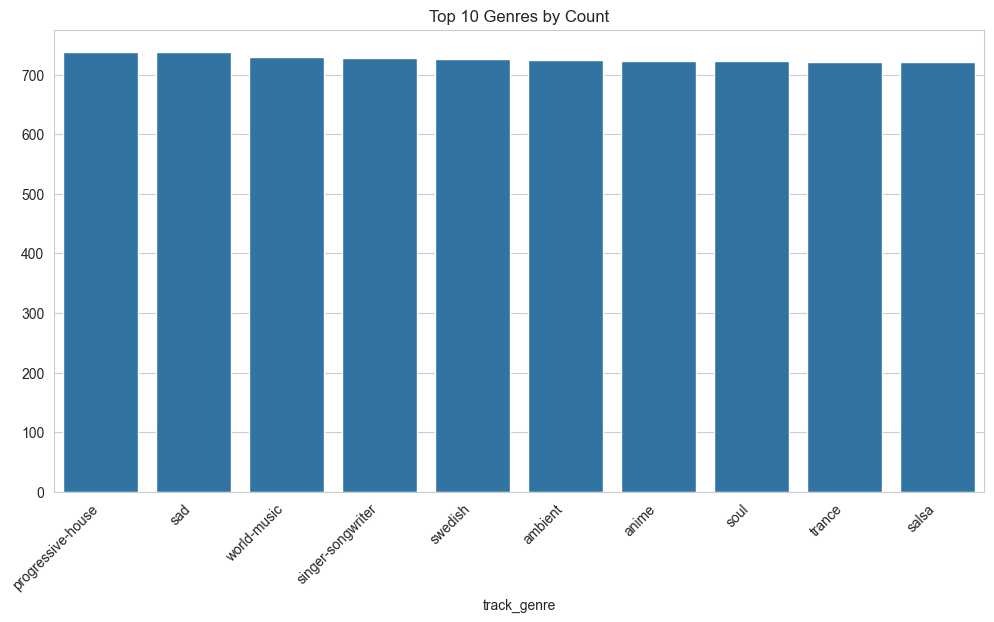

In [173]:
top_genres = df['track_genre'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title('Top 10 Genres by Count')
plt.xticks(rotation=45, ha='right')
plt.show()

É possível ver que o gênero 'sad' é o segundo gênero com maior sucesso de músicas populares. Comprovando nossa hipótese.

#### Hipótese 04: Relação inversa entre instrumentalidade e popularidade

Músicas com alto grau de instrumentalidade (pouco ou nenhum vocal) podem tender a ser menos populares, possivelmente devido à preferência do público mainstream por músicas com letras e vozes.

Text(0, 0.5, 'Instrumentalidade')

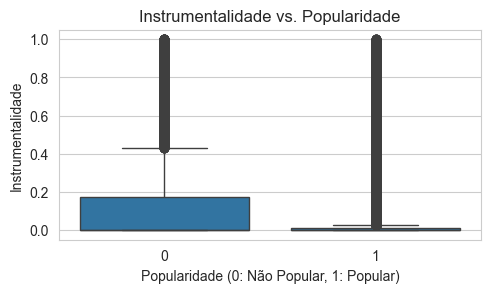

In [174]:
plt.subplot(2, 2, 4)
sns.boxplot(x='popularity_target', y='instrumentalness', data=df)
plt.title('Instrumentalidade vs. Popularidade')
plt.xlabel('Popularidade (0: Não Popular, 1: Popular)')
plt.ylabel('Instrumentalidade')

É possível observar que existem músicas populares e que são instrumentais, mas, em maioria, elas são classificadas como não populares. Comprovando nossa hipótese.

## Limpeza e Tratamento de Valores Nulos

### Tratamento de valores duplicados

Fazer a limpeza de valores duplicados é importantes pois valores duplicados podem prejudicar no aprendizado do nosso algoritmo. Para realizar a limpeza, vamos primeiro checar se existem valores duplicados e caso existirem, vamos excluir todos.

In [175]:
duplicated_values = df[df.duplicated()]
print(len(duplicated_values))

0


Como podemos ver acima, não existem valores duplicados. Assim, seguiremos com nossa análise

### Tratamento de missing values

Missing values são valores = null

É importante verificar a existência deles e resolver os valores faltantes caso existam.

In [176]:
df.isnull().sum()

track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64

Como podemos ver acima, também não existem valores faltantes.

Agora, vamos verificar valores que são iguais a 0. Como identificamos lá no começo desse notebook, já sabemos de alguns valores que não deveriam estar iguais a 0. Também vamos procurar por novos valores iguais a 0 e que não deveriam estar assim, caso existam, vamos resolver.

In [177]:
zero_count = (df == 0).sum()
print(zero_count)

track_unique_id          1
track_id                 0
artists                  0
album_name               0
track_name               0
duration_ms              0
explicit             72962
danceability            99
energy                   0
key                   9183
loudness                 0
mode                 28909
speechiness             99
acousticness            28
instrumentalness     27202
liveness                 1
valence                108
tempo                   99
time_signature         102
track_genre              0
popularity_target    40870
dtype: int64


Como podemos ver acima, as colunas 'time_signature' e 'tempo' possuem valores iguais a 0 e elas não deveriam estar assim:

1. Tempo:

- Representa a velocidade da música em batidas por minuto (BPM).
- Um valor 0 significaria que não há batidas, o que é musicalmente impossível.
- Tempos típicos variam de cerca de 60 BPM (lento) a 200 BPM (muito rápido).


2. Time signature (fórmula de compasso):

- Indica quantas batidas há por compasso e qual nota representa uma batida.
- É escrita como uma fração, por exemplo, 4/4 ou 3/4.
- Um valor 0 não faria sentido, pois implicaria em nenhuma batida por compasso.

In [178]:
df['time_signature'].value_counts()

time_signature
4    71202
3     6512
5     1274
1      710
0      102
Name: count, dtype: int64

In [179]:
print(df['tempo'].describe(), df['tempo'].value_counts())

count    79800.000000
mean       122.076559
std         29.941937
min          0.000000
25%         99.081250
50%        122.009000
75%        140.054000
max        222.605000
Name: tempo, dtype: float64 tempo
151.925    112
0.000       99
95.004      61
87.925      59
77.321      54
          ... 
124.096      1
150.085      1
199.330      1
119.502      1
182.873      1
Name: count, Length: 37292, dtype: int64


Para resolver esses 2 problemas, vamos: 

- Substituir os valores de 'time_signature' pela moda, que é 4
- Substituir os valores de 'tempo' pela mediana

In [180]:
tempo_median = df['tempo'].median()
df_treating_data = df.copy()
df_treating_data['tempo'] = df_treating_data['tempo'].replace(0,tempo_median)
df_treating_data['time_signature'] = df_treating_data['time_signature'].replace(0,4)

### Identificação de outliers e correção

As colunas que vamos visualizar e depois tratar os outliers são as colunas: 'duration_ms', 'loudness' e 'tempo'.

Realizei a escolha dessas três colunas porque todas as outras colunas numéricas se constituem de valores que vâo de 0 a 1. Algumas até possuem outliers mas são features importantes e que quero manter para preservar a pureza dos dados em features que vão de 0 a 1. Mais tarde, vamos minimizar os impactos que esses outliers podem causar com o standardScaler

Agora partindo para a identificação dos outliers que escolhemos, vamos começar visualizando em boxplot os possíveis outliers.

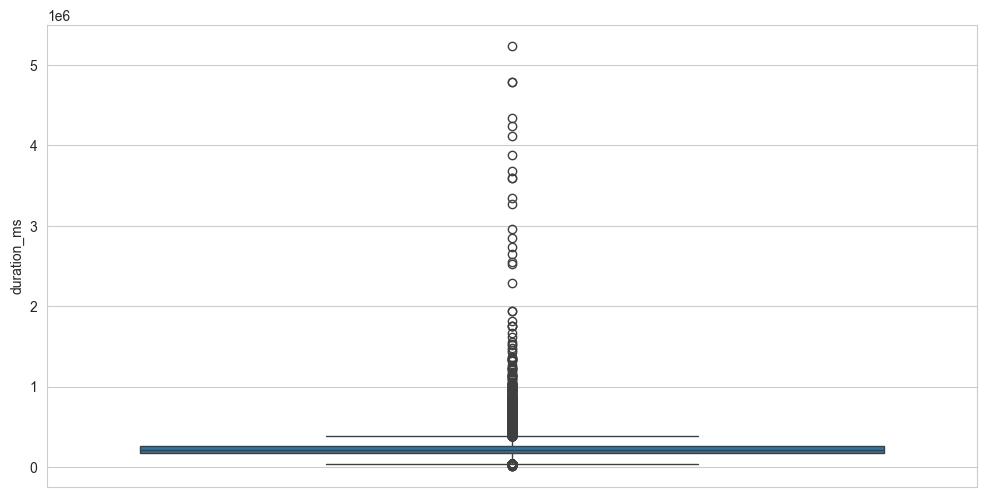

In [181]:
sns.boxplot(data=df_treating_data, y='duration_ms')
plt.show()

Observando o gráfico acima, é possívei ver que 'duration_ms' possui vários outliers, vamos guardar essa informação e em breve corrigir eles.

Agora fazendo a análise dos outliers de 'loudness', vamos desenhar outro boxplot para realizar essa visualização:

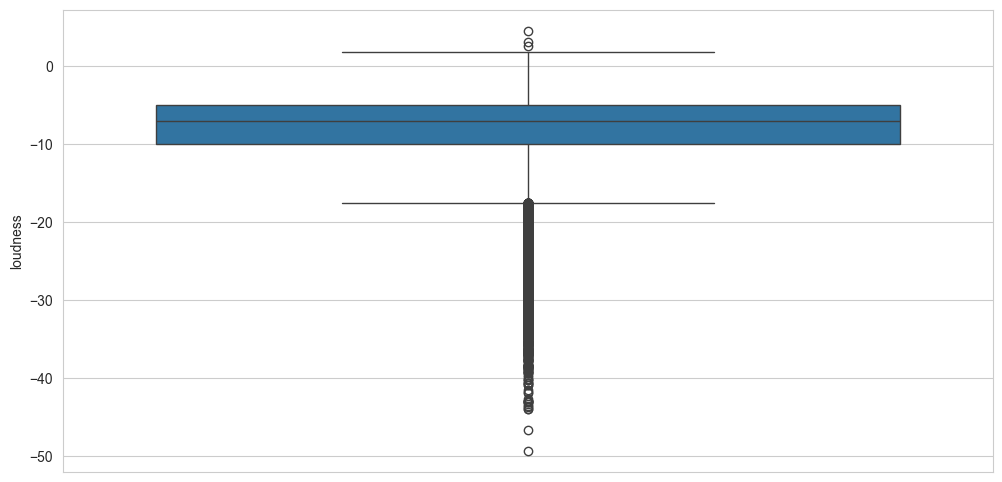

In [182]:
sns.boxplot(data=df_treating_data, y='loudness')
plt.show()

Agora fazendo a análise dos outliers de 'tempo', vamos desenhar outro boxplot para realizar essa visualização:

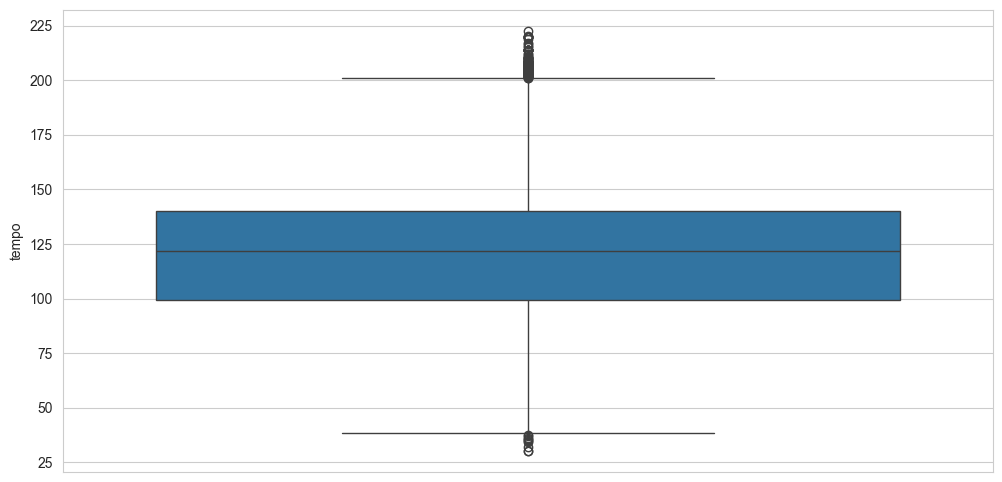

In [183]:
sns.boxplot(data=df_treating_data, y='tempo')
plt.show()

Sabendo dos outliers que 'duration_ms', 'loudness' e 'tempo' possuem, vamos agora partir para a correção deles.

Para os outliers de 'loudness' e 'tempo', decidi manter eles do jeito que estão. Pelas mesmas que citei acima, sobre as colunas que vão de 0 a 1. 

Como essas duas colunas representam caracteristicas específicas da música em questão e também podem representar escolhas específicas do artista que a fez, acho importante manter esses outliers do jeito que estão.

---

Já para os outliers de 'duration_ms', vamos agora tentar três medidas diferentes para corrigi-los:

1. Vamos manter eles intocáveis.
2. Vamos excluir todos os outliers
3. Vamos aplicar uma transformação logarítmica.

A transformação logarítmica ajuda a lidar com outliers (valores extremos) e dados distorcidos ao comprimir a amplitude dos valores, especialmente os números grandes. Isso faz com que valores extremos se tornem menos extremos, enquanto ainda preserva as diferenças relativas entre os dados.

Antes de tomar essas três medidas, vamos excluir algumas colunas que não serão importantes para o treinamento do nosso modelo, essas colunas são: 'track_id', 'track_unique_id', 'artists', 'album_name' e 'track_name'.

- track_id: Usado apenas para identificação de uma música em questão, por isso, não é importante para nosso futuro modelo.
- track_unique_id: Também usado apenas para identificação.
- artists: Poderia ser um dado importante caso nossa base de dados classificasem o nível de fama de cada artista, pois artistas famosos tendem a gerar músicas populares com mais facilidade. Como nossa base de dados não contém isso, vamos excluir essa coluna porque na situação que está, essa coluna é usada apenas para identificação.
- album_name: Como nossa base de dados não contém também uma coluna classificando o nível de popularidade do album em questão, não vamos estar utilizando essa informação.
- track_name: Usado apenas para identificação.

In [184]:
df_treating_data = df_treating_data.drop(columns=['track_unique_id', 'track_id', 'artists', 'album_name', 'track_name'])

Com essas alterações feitas, agora vamos tomar as três medidas para realizar a correção dos outliers de 'durations_ms'

1. Primeiro, vamos tomar a medida em que excluímos todos os outliers de 'duration_ms'

In [185]:
Q1 = df_treating_data['duration_ms'].quantile(0.25)
Q3 = df_treating_data['duration_ms'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_duration_outliers = df_treating_data.copy()

df_no_duration_outliers = df_no_duration_outliers[(df_no_duration_outliers['duration_ms'] >= lower_bound) & (df_no_duration_outliers['duration_ms'] <= upper_bound)]

2. Segundo, vamos aplicar a transformação logarítmica

In [186]:
# Criando uma copia para nossa segunda medida com os outliers
df_duration_log = df_treating_data.copy()

# fazendo a transformacao logaritma
df_duration_log['duration_log'] = np.log1p(df_duration_log['duration_ms'])

# excluindo a coluna de duracao normal porque nao vamos utilizar ela nessa base de dados
df_duration_log = df_duration_log.drop(columns=['duration_ms'])

Agora é possível observar que estamos com três base de dados:

1. df_treating_data: Contém os outliers de 'duration_ms' sem alterações
2. df_no_duration_outliers: Não contém nenhum outlier de 'duration_ms'
3. df_duration_log: Contém os outliers mas com a transformação log aplicada em todos.

Agora, seguiremos com esses 3 modelos até o treinamento do nosso modelo, onde veremos qual base de dados resultará um melhor resultado.

## Codificação de Variáveis Categóricas

Aplique técnicas apropriadas de codificação para transformar variáveis categóricas em formatos utilizáveis em modelos preditivos, garantindo que a informação essencial não seja perdida no processo.

Agora, entramos na etapa de codificar as variáveis categóricas. As únicas 2 colunas que não são numéricas e precisar sem codificadas, são 'explicit' que é uma coluna boolean e 'track_genre' que é uma coluna categórica. 

Para garantir que não vamos perder as informações essenciais nessa etapa, vamos codificar as variáveis de 'track_genre' com um método chamado Target Encode. 

Já a coluna 'explicit', por ser uma coluna boolean, para codifica-lá, basta transformar os valores em valores int. Faremos isso abaixo.

É importante lembrar que, como temos 3 base de dados, vamos codificar as colunas de cada uma:

In [187]:
df_treating_data['explicit'] = df_treating_data['explicit'].astype(int)
df_no_duration_outliers['explicit'] = df_no_duration_outliers['explicit'].astype(int)
df_duration_log['explicit'] = df_duration_log['explicit'].astype(int)

Agora abaixo, criamos a função para codificar nossa coluna 'track_genre'. 

A escolha do Target Encode foi feita porque enfrentamos o desafio de lidar com a variável categórica 'track_genre', que possui alta cardinalidade (114 categorias únicas). Para abordar esse problema de maneira eficaz, implementamos a técnica de Target Encoding.

Target Encoding é uma técnica usada para converter variáveis categóricas em valores numéricos. Diferentemente de métodos como mais utilizados como LabelEncoder, o Target Encoding leva em consideração a variável alvo (popularity_target) ao realizar a codificação.

1. Para cada categoria na variável categórica (no nosso caso, cada gênero musical), calculamos a média da variável alvo.
2. Substituímos cada categoria pelo valor médio calculado.
3. Para evitar overfitting, utilizamos uma abordagem de validação cruzada na implementação.

Mas por que estamos usando o Target Encoder nesse caso ?

1. Alta Cardinalidade: Com 114 gêneros musicais únicos, métodos como One-Hot Encoding criariam um número excessivo de features, potencialmente levando a problemas de dimensionalidade.
2. Captura de Informação Relevante: O Target Encoding captura a relação entre cada gênero musical e a popularidade da música, fornecendo uma representação numérica significativa.
3. Eficiência Computacional: Reduz a dimensionalidade dos dados sem perder informações cruciais sobre a relação entre gênero e popularidade.
4. Tratamento de Categorias Raras: Lida bem com gêneros musicais que aparecem com pouca frequência no dataset.

O Target Encoding nos permite transformar a informação categórica dos gêneros musicais em uma representação numérica que preserva e destaca a relação entre gênero e popularidade.


In [188]:
def target_encode_cv(df, column, target, n_splits=5):
    encoded = np.zeros(len(df))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(df):
        target_means = df.iloc[train_idx].groupby(column)[target].mean()
        encoded[val_idx] = df[column].iloc[val_idx].map(target_means)
    
    global_mean = df[target].mean()
    encoded = np.where(np.isnan(encoded), global_mean, encoded)
    
    return encoded

In [189]:
df_treating_data['track_genre_encoded'] = target_encode_cv(df_treating_data, 'track_genre', 'popularity_target')

# Verificação dos resultados
print(df_treating_data[['track_genre', 'track_genre_encoded', 'popularity_target']].head(10))
print("\nCorrelação entre 'track_genre_encoded' e 'popularity_target':")
print(df_treating_data['track_genre_encoded'].corr(df['popularity_target']))
df_treating_data = df_treating_data.drop(columns='track_genre')

  track_genre  track_genre_encoded  popularity_target
0        goth             0.190654                  0
1       opera             0.185442                  0
2         idm             0.093458                  1
3   classical             0.109347                  0
4      techno             0.654741                  0
5         pop             0.675627                  1
6    acoustic             0.636364                  1
7       study             0.304878                  0
8       study             0.312937                  0
9      trance             0.626549                  0

Correlação entre 'track_genre_encoded' e 'popularity_target':
0.5817232532620756


In [190]:
df_no_duration_outliers['track_genre_encoded'] = target_encode_cv(df_no_duration_outliers, 'track_genre', 'popularity_target')

# Verificação dos resultados
print(df_no_duration_outliers[['track_genre', 'track_genre_encoded', 'popularity_target']].head(10))
print("\nCorrelação entre 'track_genre_encoded' e 'popularity_target':")
print(df_no_duration_outliers['track_genre_encoded'].corr(df['popularity_target']))
df_no_duration_outliers = df_no_duration_outliers.drop(columns='track_genre')

  track_genre  track_genre_encoded  popularity_target
0        goth             0.205825                  0
1       opera             0.166976                  0
2         idm             0.103814                  1
3   classical             0.103896                  0
4      techno             0.597911                  0
5         pop             0.649728                  1
6    acoustic             0.640596                  1
7       study             0.304114                  0
8       study             0.312500                  0
9      trance             0.630290                  0

Correlação entre 'track_genre_encoded' e 'popularity_target':
0.5774355242648714


In [191]:
df_duration_log['track_genre_encoded'] = target_encode_cv(df_duration_log, 'track_genre', 'popularity_target')

# Verificação dos resultados
print(df_duration_log[['track_genre', 'track_genre_encoded', 'popularity_target']].head(10))
print("\nCorrelação entre 'track_genre_encoded' e 'popularity_target':")
print(df_duration_log['track_genre_encoded'].corr(df['popularity_target']))
df_duration_log = df_duration_log.drop(columns='track_genre')

  track_genre  track_genre_encoded  popularity_target
0        goth             0.190654                  0
1       opera             0.185442                  0
2         idm             0.093458                  1
3   classical             0.109347                  0
4      techno             0.654741                  0
5         pop             0.675627                  1
6    acoustic             0.636364                  1
7       study             0.304878                  0
8       study             0.312937                  0
9      trance             0.626549                  0

Correlação entre 'track_genre_encoded' e 'popularity_target':
0.5817232532620756


Análisando os resultados acima, podemos ver que o Target Encoding capturou informações relevantes sobre a relação entre os gêneros musicais e a popularidade, sem criar uma relação perfeita que poderia levar a overfitting.

Por exemplo, "pop" tem um valor codificado de 0.675627, sugerindo que cerca de 67.56% das músicas pop são populares.

Essas informações serão valiosas no momento em que formos treinar os algoritmos.

## Seleção de Features

As features que vamos incluir em nosso modelo preditivo são: 

duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'popularity_target', 'track_genre_encoded'

Justificativa para a escolha dessas features:

1. duration_ms: Duração da faixa em milissegundos
2. explicit: Indicador de conteúdo explícito
3. danceability: Quão adequada a faixa é para dançar
4. energy: Medida de intensidade e atividade
5. key: Tonalidade da faixa
6. loudness: Volume geral da faixa em decibéis
7. mode: Modalidade da faixa (maior ou menor)
8. speechiness: Presença de palavras faladas
9. acousticness: Medida de quão acústica é a faixa
10. instrumentalness: Predição da ausência de vocais
11. liveness: Presença de público na gravação
12. valence: Positividade musical da faixa
13. tempo: Velocidade ou ritmo estimado em BPM
14. time_signature: Fórmula de compasso estimada
15. popularity_target: Alvo de popularidade (variável dependente)
16. track_genre_encoded: Gênero da faixa (codificado)

Justificativa da Seleção

1. Características Acústicas: danceability, energy, loudness, acousticness, instrumentalness, valence, e tempo foram incluídas por representarem aspectos fundamentais do som e da percepção musical, que podem influenciar diretamente a popularidade.
2. Estrutura Musical: key, mode, e time_signature foram mantidas por fornecerem informações sobre a estrutura musical, que pode afetar a acessibilidade e apelo da faixa.
3. Conteúdo: explicit e speechiness foram incluídas por poderem influenciar a recepção e distribuição da música em diferentes plataformas e faixas etárias.
4. Experiência de Escuta: duration_ms e liveness foram mantidas por afetarem a experiência de escuta, potencialmente impactando o engajamento do ouvinte.
5. Contexto: track_genre_encoded foi incluída por fornecer contexto importante sobre o estilo musical, que pode ser crucial para entender padrões de popularidade em diferentes nichos.
6. Alvo: popularity_target é a variável dependente que o modelo tentará prever.

- Vale também levantar o ponto de que para prever com a melhor acurácia possível, é importante manter o máximo de colunas porque os dados parecem estar extremamente conectados entre si.

Pré-processamento e transformação:

1. Para tentar ao máximo garantir o melhor resultado possível, em breve, vamos criar novas base de dados e realizar o escalonamento de todos os valores. (Vale levantar o ponto de que vamos testar todas as bases de dados e escolher o melhor resultado gerado.)

## Construção e Avaliação do Modelo